
Rev_NLP_2_dataset_youtube.ipynb

Dibuat untuk melakukan text analytics dan sentiment analysis berbasis data YouTube.
Dataset: youtube_video.csv
Ukuran: 33.64 MB
Sumber: Dataset berisi informasi detail video YouTube terakhir yang diunggah oleh berbagai channel.
"""

In [2]:
# ==============================
# 1️⃣ KONEKSI KE GOOGLE DRIVE
# ==============================

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Kode ini digunakan untuk menghubungkan Google Colab dengan Google Drive. Setelah dijalankan, Colab dapat membaca dan menulis file di Drive menggunakan path /content/drive. Output yang muncul adalah:

Mounted at /content/drive


Artinya Drive sudah terhubung dan siap digunakan untuk memuat dataset atau menyimpan file.

In [3]:
# ==============================
# 2️⃣ IMPORT PACKAGE
# ==============================

!pip install unidecode gensim        # Menginstal library tambahan yang belum ada di lingkungan Colab:
                                     # - unidecode: untuk menghapus aksen pada huruf (misalnya “é” → “e”)
                                     # - gensim: digunakan untuk pemrosesan teks dan model Word2Vec

import os                            # Mengakses fungsi sistem operasi (misalnya membaca file & folder)
import pandas as pd                  # Untuk membaca, memproses, dan menganalisis data berbentuk tabel (DataFrame)
import numpy as np                   # Untuk operasi numerik seperti array dan perhitungan matematis
import re                            # Modul regex (regular expression), berguna untuk membersihkan teks
import nltk                          # Natural Language Toolkit — pustaka NLP untuk tokenisasi, stopwords, dll.
from unidecode import unidecode      # Menghapus karakter non-ASCII atau tanda aksen pada teks (normalisasi teks)
from time import time                # Mengukur waktu eksekusi kode (berguna untuk melihat kecepatan proses)

from gensim.models import Word2Vec   # Membuat model Word2Vec (mengubah kata menjadi vektor numerik)
from gensim.models.phrases import Phrases, Phraser  # Menggabungkan kata yang sering muncul bersama (bigram/trigram)

from sklearn.cluster import KMeans   # Algoritma unsupervised learning untuk pengelompokan teks (clustering)
from sklearn.feature_extraction.text import TfidfVectorizer
                                     # Mengubah teks menjadi representasi numerik berdasarkan frekuensi kata (TF-IDF)
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
                                     # Metrik evaluasi model (biasanya untuk supervised learning, tapi bisa digunakan juga untuk analisis hasil cluster)
from IPython.display import display  # Untuk menampilkan DataFrame atau output tabel dengan format yang rapi di Jupyter/Colab

# Download stopwords dan tokenizer dari NLTK
nltk.download('stopwords')           # Mengunduh daftar kata umum (seperti "the", "is", "and") untuk dihapus dari teks
nltk.download('punkt')               # Mengunduh tokenizer bawaan NLTK untuk memecah teks menjadi kata atau kalimat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 75.3 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Penjelasan singkat:

!pip install → Menginstal library tambahan (unidecode untuk normalisasi teks, gensim untuk Word2Vec dan NLP).

import ... → Mengimpor paket yang diperlukan untuk:

Memproses data tabel (pandas), operasi numerik (numpy), regex (re), NLP (nltk), Word2Vec (gensim), clustering (sklearn).

nltk.download('stopwords') & punkt → Mengunduh sumber daya NLTK untuk tokenisasi dan stopwords.

Output → Menunjukkan bahwa library berhasil diinstal dan NLTK berhasil mendownload resource yang dibutuhkan.

In [4]:
# ==============================
# 3️⃣ CEK PATH DATASET
# ==============================

path = '/content/drive/MyDrive/dataset'
os.listdir(path)

['youtube_video.csv',
 'result_word2vec.model.wv.vectors.npy',
 'result_word2vec.model.syn1neg.npy',
 'result_word2vec.model']

Penjelasan singkat:

path → Menyimpan lokasi folder dataset di Google Drive.

os.listdir(path) → Menampilkan semua file dan folder yang ada di folder tersebut.

Arti hasil:

youtube_video.csv → File dataset utama berisi informasi video YouTube.

result_word2vec.model dan file .npy → File model Word2Vec yang sebelumnya dibuat, termasuk vektor kata dan parameter model.

Fungsinya: memastikan dataset dan file model yang diperlukan sudah tersedia sebelum analisis atau pelatihan model.

In [7]:
# ==============================
# 4️⃣ LOAD DATASET YOUTUBE
# ==============================

# File: youtube_video.csv
# Format CSV UTF-8
# Lokasi: /content/drive/MyDrive/dataset/youtube_video.csv
# Kolom:
# 1. video_id          → ID unik video di YouTube
# 2. title             → Judul video
# 3. channel_name      → Nama channel
# 4. channel_id        → ID unik channel
# 5. view_count        → Jumlah views
# 6. like_count        → Jumlah likes
# 7. comment_count     → Jumlah komentar publik
# 8. published_date    → Waktu publikasi (ISO 8601)
# 9. thumbnail         → URL thumbnail video

df_youtube = pd.read_csv(                                  # Membaca file CSV dan menyimpannya ke DataFrame pandas
    os.path.join(path, 'youtube_video.csv'),                # Menggabungkan path folder dan nama file CSV
    encoding='utf-8',                                       # Menggunakan encoding UTF-8 agar karakter spesial terbaca
    on_bad_lines='skip'                                     # Melewati baris data yang rusak atau tidak terbaca
)

print("=== YOUTUBE VIDEO DATASET ===")                      # Menampilkan teks pembuka untuk identifikasi dataset
display(df_youtube.head())                                  # Menampilkan 5 baris pertama dari dataset


=== YOUTUBE VIDEO DATASET ===


,video_id,title,channel_name,channel_id,view_count,like_count,comment_count,published_date,thumbnail
0,QwtOeDR-N3g,Why do Human Feet Wash up on This Beach? | Fas...,Fascinating Horror,UCFXad0mx4WxY1fXdbvtg0CQ,33955,1817,119,2025-10-03T09:15:02Z,https://i.ytimg.com/vi/QwtOeDR-N3g/hqdefault.jpg
1,K0fw1uiSGE0,"Range Rover SV (2025) - The King of the City, ...",CAR TV,UCs_gcVRMHEx5mVXfQ7icQTg,59659,1130,22,2025-10-08T09:10:46Z,https://i.ytimg.com/vi/K0fw1uiSGE0/hqdefault.jpg
2,StuKQpzfyjI,Bruce Wayne Becomes Batman - NEW Gotham City U...,Just4fun290,UCdPG86Ahrf9A8YzBnFDAaEg,8658,89,0,2025-10-04T15:00:06Z,https://i.ytimg.com/vi/StuKQpzfyjI/hqdefault.jpg
3,C91854vbs8I,How the music of Mario Kart has evolved,Thomas Game Docs,UCyy7dZhgfeMMctSoo3wDXlQ,161045,5391,239,2025-05-08T15:32:15Z,https://i.ytimg.com/vi/C91854vbs8I/hqdefault.jpg
4,1DaHVSmx160,My bulldog loves mess... you can see that )))),Enzo English Bulldog,UCkk_2IfQ52OJcCUXOrJBtnw,7620,94,24,2021-08-12T15:33:31Z,https://i.ytimg.com/vi/1DaHVSmx160/hqdefault.jpg


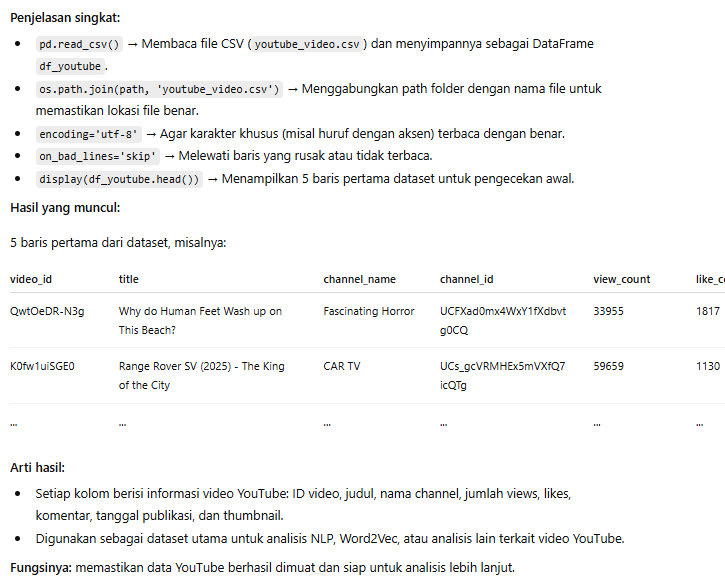

In [8]:
# ==============================
# 5️⃣ PENJELASAN VARIABEL UTAMA
# ==============================

# df_youtube : DataFrame utama yang menyimpan seluruh data video YouTube
# df_youtube['title'] : Digunakan sebagai sumber teks untuk analisis NLP (Natural Language Processing)
# df_youtube['view_count'] : Data numerik yang dapat digunakan untuk analisis popularitas video
# df_youtube['like_count'] dan ['comment_count'] : Metrik interaksi yang menunjukkan engagement pengguna

print("\n--- Informasi Dataset ---")                        # Menampilkan informasi struktur dataset
print(df_youtube.info())                                    # Menampilkan tipe data, jumlah kolom, dan data null

print("\n--- Statistik Numerik ---")                        # Menampilkan ringkasan statistik deskriptif kolom numerik
display(df_youtube.describe())                              # Menampilkan hasil statistik seperti mean, std, min, max, dll.



--- Informasi Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155669 entries, 0 to 155668
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   video_id        155669 non-null  object
 1   title           155669 non-null  object
 2   channel_name    155669 non-null  object
 3   channel_id      155669 non-null  object
 4   view_count      155669 non-null  int64 
 5   like_count      155669 non-null  int64 
 6   comment_count   155669 non-null  int64 
 7   published_date  155669 non-null  object
 8   thumbnail       155669 non-null  object
dtypes: int64(3), object(6)
memory usage: 10.7+ MB
None

--- Statistik Numerik ---


,view_count,like_count,comment_count
count,1.556690e+05,1.556690e+05,1.556690e+05
mean,1.301435e+06,1.995820e+04,8.226443e+02
std,2.310617e+07,1.471102e+05,8.179233e+03
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.807000e+03,1.200000e+02,4.000000e+00
50%,3.614900e+04,8.520000e+02,3.600000e+01
75%,2.273730e+05,5.524000e+03,2.440000e+02
max,5.367569e+09,1.411948e+07,1.310470e+06


| Baris            | Arti                 | Penjelasan                                                                                                                 |
| :--------------- | :------------------- | :------------------------------------------------------------------------------------------------------------------------- |
| **count**        | Jumlah data          | Ada berapa baris/entri yang memiliki nilai (bukan kosong). Contoh: 155,669 video punya nilai view_count.                   |
| **mean**         | Rata-rata            | Nilai rata-rata dari semua video. Contoh: rata-rata view_count = 1.301.435 berarti rata-rata video punya 1,3 juta view.    |
| **std**          | Standar deviasi      | Mengukur seberapa tersebar datanya. Kalau besar → datanya bervariasi jauh (ada video yang sangat viral dan ada yang sepi). |
| **min**          | Nilai minimum        | Nilai terkecil di kolom itu. Misalnya ada video dengan 0 view.                                                             |
| **25%**          | Kuartil pertama (Q1) | 25% data ada di bawah nilai ini. Artinya 1/4 video punya view ≤ 6.807.                                                     |
| **50% (median)** | Nilai tengah         | Setengah video punya view di bawah 36.149, setengahnya di atas.                                                            |
| **75%**          | Kuartil ketiga (Q3)  | 75% video punya view ≤ 227.373.                                                                                            |
| **max**          | Nilai maksimum       | Video paling viral punya 5.367.569.000 view (5,3 miliar view!).                                                            |


In [9]:
# ==============================
# 6️⃣ MEMBUAT DATAFRAME TEKS
# ==============================

df = df_youtube[['title']].copy()                           # Membuat DataFrame baru berisi hanya kolom 'title'
df.columns = ['text']                                       # Mengganti nama kolom menjadi 'text' untuk keperluan NLP

print("\n=== CONTOH TEKS UNTUK NLP ===")                    # Menampilkan 5 contoh teks awal untuk analisis teks
display(df.head())                                          # Melihat isi kolom 'text' sebagai sampel awal



=== CONTOH TEKS UNTUK NLP ===


,text
0,Why do Human Feet Wash up on This Beach? | Fas...
1,"Range Rover SV (2025) - The King of the City, ..."
2,Bruce Wayne Becomes Batman - NEW Gotham City U...
3,How the music of Mario Kart has evolved
4,My bulldog loves mess... you can see that ))))


In [10]:
# ==============================
# 7️⃣ PREPROCESSING DATA TEKS YOUTUBE
# ==============================

"""
Tujuan tahap preprocessing adalah untuk:
1. Mengecek kondisi awal data (jumlah baris, kolom, dan tipe data)
2. Membersihkan data dari missing value atau duplikasi
3. Melakukan cleaning teks agar siap digunakan untuk analisis NLP
"""

# 1️⃣ Melihat informasi struktur DataFrame
print("=== Info DataFrame ===")
df.info()  # df.info() sudah otomatis print, jadi print() opsional

# 2️⃣ Mengecek missing value
print("\n=== Missing Value per Kolom ===")
print(df.isnull().sum())

# 3️⃣ Mengecek data duplikat
print("\n=== Data Duplikat ===")
print(df[df.duplicated()])

# 4️⃣ Menghapus duplikat dan reset index
df = df.drop_duplicates().reset_index(drop=True)
print("\n=== Data setelah Hapus Duplikat ===")
print(df.shape)

# 5️⃣ Contoh menampilkan 5 baris pertama untuk lihat sekilas data
print("\n=== 5 Baris Pertama Data ===")
print(df.head())


=== Info DataFrame ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155669 entries, 0 to 155668
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    155669 non-null  object
dtypes: object(1)
memory usage: 1.2+ MB

=== Missing Value per Kolom ===
text    0
dtype: int64

=== Data Duplikat ===
                                                     text
1112      RA MẮT SỮA ĐẬU NÀNH CAO CANXI NHẤT VIỆT NAM ĐÂY
2412    LIVE -  त्रिदोष जन्य मोटापा, मधुमेह, उच्च रक्त...
2542    || BEST SCENE || MOGALIREKULU ||  MANJULA NAID...
2794    ROAD TO GRANDMASTER | CS RANKED NEW SEASON #en...
2850    Veera Vanakkam | வீர வணக்கம் - Sneak Peek | Sa...
...                                                   ...
155417   Powerful Combos Megacorp don't want you to know!
155603       Bigg Boss Tamil S9 UNSEEN | 8th October 2025
155616               The Dead South - You Are My Sunshine
155644  طلاب من مدرسة الأمانة في بانكستاون شاركوا مباش...

In [11]:
# ==============================
# 8️⃣ CLEANING TEKS (TEXT CLEANING)
# ==============================

"""
Langkah berikut melakukan pembersihan teks agar lebih bersih dan seragam:
- Menghapus tag HTML
- Menghapus URL/link
- Menghapus username (misal @user)
- Menghapus tanda baca
- Mengubah teks ke huruf kecil
- Menghapus stopwords (kata umum seperti 'the', 'is', dll)
"""

# Vocab untuk stopwords bahasa Inggris
stops = set(nltk.corpus.stopwords.words("english"))

# Membuat pola regex (regular expression) untuk membersihkan teks
html_tag = re.compile(r'<.*?>')            # Menghapus HTML tag
http_link = re.compile(r'https://\S+')     # Menghapus link https
www_link = re.compile(r'www\.\S+')         # Menghapus link www
user_name = re.compile(r'\@[a-z0-9]+')     # Menghapus mention seperti @user
punctuation = re.compile(r'[^\w\s]')       # Menghapus tanda baca

# Fungsi untuk cleaning teks
def data_cleaning(text, stopwords=False):
    text = unidecode(text)                 # Normalisasi unicode (misal é → e)
    text = text.lower()                    # Ubah semua huruf jadi kecil
    text = re.sub(html_tag, '', text)      # Hapus HTML
    text = re.sub(http_link, '', text)     # Hapus https link
    text = re.sub(www_link, '', text)      # Hapus www link
    text = re.sub(user_name, '', text)     # Hapus username
    text = re.sub(punctuation, '', text)   # Hapus tanda baca
    text = text.split()                    # Tokenisasi (pisah jadi kata)
    if stopwords:                          # Jika stopwords=True, hapus kata umum
        text = [w for w in text if not w in stops]
    return text

# Terapkan fungsi cleaning pada kolom teks
df['text_clean'] = df['text'].apply(lambda x: data_cleaning(x, stopwords=True))

# Lihat 5 data awal setelah cleaning
df.head()

# Mengecek ukuran data setelah cleaning
df.shape

(153322, 2)

In [12]:
# ==============================
# 9️⃣ FILTER TEKS PENDEK
# ==============================

"""
Tahap ini menghapus data yang terlalu pendek (hanya 1 kata),
karena biasanya tidak bermakna untuk analisis NLP.
"""

data_clean = df[df.text_clean.str.len() > 1]
data_clean.shape  # Menunjukkan jumlah baris tersisa

# Cek 5 data awal hasil filter
data_clean.head()

,text,text_clean
0,Why do Human Feet Wash up on This Beach? | Fas...,"[human, feet, wash, beach, fascinating, horror..."
1,"Range Rover SV (2025) - The King of the City, ...","[range, rover, sv, 2025, king, city, grand, lu..."
2,Bruce Wayne Becomes Batman - NEW Gotham City U...,"[bruce, wayne, becomes, batman, new, gotham, c..."
3,How the music of Mario Kart has evolved,"[music, mario, kart, evolved]"
4,My bulldog loves mess... you can see that )))),"[bulldog, loves, mess, see]"


In [13]:
# ==============================
# 10️⃣ N-GRAM CONCEPT
# ==============================

"""
N-Gram adalah metode pemrosesan teks yang membentuk kombinasi dari n kata secara berurutan.
Model ini berguna untuk memahami konteks kata yang muncul secara berurutan,
misalnya untuk prediksi kata berikutnya atau analisis hubungan antar kata.
"""

# Import fungsi ngrams dari nltk
from nltk import ngrams

# Membuat list kosong untuk menampung unigram, bigram, dan trigram
unigram = []
bigram = []
trigram = []

# Menampilkan contoh dari 1 kalimat pertama di kolom text_clean
for words in data_clean["text_clean"][:1]:      # Ambil satu baris pertama dari kolom text_clean
    list_bigram = list(ngrams(words, 2))        # Bentuk pasangan 2 kata (bigram)
    list_trigram = list(ngrams(words, 3))       # Bentuk kombinasi 3 kata (trigram)

    for word in words:                          # Simpan setiap kata tunggal ke dalam unigram
        unigram.append(word)
    for word in list_bigram:                    # Simpan setiap pasangan kata ke dalam bigram
        bigram.append(word)
    for word in list_trigram:                   # Simpan setiap kombinasi tiga kata ke dalam trigram
        trigram.append(word)

# Menampilkan hasil contoh
print("Kalimat Asli :", data_clean['text'][:1].values[0])
print("\nUnigram :", unigram)
print("\nBigram :", bigram)
print("\nTrigram :", trigram)

"""
Dari hasil di atas terlihat perbedaan antara:
- Unigram → kata per kata
- Bigram  → dua kata berurutan
- Trigram → tiga kata berurutan

Pendekatan ini sering digunakan untuk:
• Menganalisis konteks kalimat
• Prediksi kata berikutnya
• Deteksi frase (kata yang sering muncul bersama)
"""


Kalimat Asli : Why do Human Feet Wash up on This Beach? | Fascinating Horror Shorts

Unigram : ['human', 'feet', 'wash', 'beach', 'fascinating', 'horror', 'shorts']

Bigram : [('human', 'feet'), ('feet', 'wash'), ('wash', 'beach'), ('beach', 'fascinating'), ('fascinating', 'horror'), ('horror', 'shorts')]

Trigram : [('human', 'feet', 'wash'), ('feet', 'wash', 'beach'), ('wash', 'beach', 'fascinating'), ('beach', 'fascinating', 'horror'), ('fascinating', 'horror', 'shorts')]


'\nDari hasil di atas terlihat perbedaan antara:\n- Unigram → kata per kata\n- Bigram  → dua kata berurutan\n- Trigram → tiga kata berurutan\n\nPendekatan ini sering digunakan untuk:\n• Menganalisis konteks kalimat\n• Prediksi kata berikutnya\n• Deteksi frase (kata yang sering muncul bersama)\n'

In [14]:
# ==============================
# 11️⃣ MELIHAT BANTUAN / DOKUMENTASI PHRASES
# ==============================

"""
Bagian ini digunakan untuk melihat fungsi dan parameter yang dimiliki oleh
kelas Phrases di Gensim. Dokumentasi ini membantu memahami bagaimana model
bigram bekerja dan parameter apa saja yang bisa disesuaikan.
"""

help(Phrases)


Help on class Phrases in module gensim.models.phrases:

class Phrases(_PhrasesTransformation)
 |  Phrases(sentences=None, min_count=5, threshold=10.0, max_vocab_size=40000000, delimiter='_', progress_per=10000, scoring='default', connector_words=frozenset())
 |
 |  Detect phrases based on collocation counts.
 |
 |  Method resolution order:
 |      Phrases
 |      _PhrasesTransformation
 |      gensim.interfaces.TransformationABC
 |      gensim.utils.SaveLoad
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, sentences=None, min_count=5, threshold=10.0, max_vocab_size=40000000, delimiter='_', progress_per=10000, scoring='default', connector_words=frozenset())
 |      Parameters
 |      ----------
 |      sentences : iterable of list of str, optional
 |          The `sentences` iterable can be simply a list, but for larger corpora, consider a generator that streams
 |          the sentences directly from disk/network, See :class:`~gensim.models.word2vec.BrownCorpu

In [15]:
# ==============================
# 12️⃣ MEMBENTUK MODEL BIGRAM DARI DATASET
# ==============================

"""
Bagian ini menggunakan model 'Phrases' dari Gensim untuk mengenali pasangan kata
yang sering muncul bersama (contohnya 'new york' atau 'machine learning') dan
menggabungkannya menjadi satu token seperti 'new_york'.
"""

# Import Phrases dan Phraser dari Gensim
from gensim.models.phrases import Phrases, Phraser

# Membentuk daftar kata dari setiap baris data_clean
sent = [row for row in data_clean["text_clean"]]

# Membuat model bigram menggunakan Gensim Phrases
# min_count=3 → pasangan kata yang muncul minimal 3 kali dianggap satu kesatuan
# progress_per → menampilkan progres setiap 50.000 baris data
phrases = Phrases(sent, min_count=3, progress_per=50000)

# Membuat model bigram yang lebih efisien dengan Phraser
bigram = Phraser(phrases)

# Menerapkan model bigram pada seluruh dataset
sentences = bigram[sent]

# Menampilkan hasil contoh setelah bigram diterapkan
print("Contoh hasil setelah Bigram diterapkan:\n", sentences[1])




Contoh hasil setelah Bigram diterapkan:
 ['range_rover', 'sv', '2025', 'king', 'city', 'grand', 'luxury_suv']


In [16]:
# ==============================
# 13️⃣ CONTOH PENERAPAN BIGRAM PADA KALIMAT BARU
# ==============================

"""
Bagian ini mendemonstrasikan bagaimana model bigram yang sudah dibuat
dapat digunakan untuk memproses kalimat baru di luar dataset.
"""

example = 'commonly known as the united states'
example = example.split()

print("Sebelum Bigram :", example)
print("Sesudah Bigram :", bigram[example])


Sebelum Bigram : ['commonly', 'known', 'as', 'the', 'united', 'states']
Sesudah Bigram : ['commonly', 'known', 'as', 'the', 'united_states']


POS Tagging

In [36]:
import nltk
import pandas as pd

# Download library NLTK yang diperlukan
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('maxent_ne_chunker')
nltk.download('punkt')


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [37]:
# Contoh kalimat
text = ["European authorities fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices."]

pos_tag_list = []

for sentence in text:
    words = sentence.split()
    tagged = nltk.pos_tag(words)
    for j in tagged:
        pos_tag_list.append(j)

print(pos_tag_list)


[('European', 'JJ'), ('authorities', 'NNS'), ('fined', 'VBD'), ('Google', 'NNP'), ('a', 'DT'), ('record', 'NN'), ('$5.1', 'NN'), ('billion', 'CD'), ('on', 'IN'), ('Wednesday', 'NNP'), ('for', 'IN'), ('abusing', 'VBG'), ('its', 'PRP$'), ('power', 'NN'), ('in', 'IN'), ('the', 'DT'), ('mobile', 'JJ'), ('phone', 'NN'), ('market', 'NN'), ('and', 'CC'), ('ordered', 'VBD'), ('the', 'DT'), ('company', 'NN'), ('to', 'TO'), ('alter', 'VB'), ('its', 'PRP$'), ('practices.', 'NN')]


In [38]:
import nltk

# Download resource tagsets_json
nltk.download('tagsets_json')

# Coba lagi menampilkan arti tag
print("\n=== Arti Tag 'JJ' ===")
nltk.help.upenn_tagset('JJ')  # adjective



=== Arti Tag 'JJ' ===
JJ: adjective or numeral, ordinal
    third ill-mannered pre-war regrettable oiled calamitous first separable
    ectoplasmic battery-powered participatory fourth still-to-be-named
    multilingual multi-disciplinary ...


[nltk_data] Downloading package tagsets_json to /root/nltk_data...
[nltk_data]   Package tagsets_json is already up-to-date!


Import & Set Parameter Word2Vec

In [39]:
## ==============================
## Word2Vec
## ==============================
# Word2Vec adalah metode embedding yang mengubah kata menjadi vektor angka
# Vektor ini bisa digunakan untuk mengukur kedekatan atau kemiripan kata

import multiprocessing
from gensim.models import Word2Vec
from time import time


In [40]:
# ==============================
# Set Parameter Word2Vec
# ==============================
min_count = 3                 # Abaikan kata yang jarang muncul
window = 4                    # Konteks kiri-kanan untuk prediksi kata
size = 250                    # Dimensi vektor embedding
sample = 1e-5                 # Probabilitas subsampling kata sering muncul
negative = 20                 # Jumlah negative sampling
workers = multiprocessing.cpu_count()-1  # Gunakan semua core CPU kecuali 1



In [41]:
# ==============================
# Membuat Model Word2Vec
# ==============================
w2v_model = Word2Vec(min_count=min_count,
                     window=window,
                     vector_size=size,
                     sample=sample,
                     negative=negative,
                     workers=workers)

# Build vocabulary
start = time()
w2v_model.build_vocab(sentences, progress_per=50000)
print('Waktu membangun vocab : {} menit'.format(round((time() - start)/60, 2)))

# Training model Word2Vec
start = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Waktu train model : {} menit'.format(round((time() - start)/60, 2)))

# Optimasi memory
w2v_model.init_sims(replace=True)


Waktu membangun vocab : 0.04 menit


/tmp/ipython-input-668754840.py:22: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


Waktu train model : 3.92 menit


In [42]:
# ==============================
# Menyimpan Model
# ==============================
model_name = "result_word2vec.model"
w2v_model.save(os.path.join(path, model_name))

# ==============================
# Replace Bigram pada Dataset
# ==============================
data_final = data_clean.copy()
data_final['old_text'] = data_final.text_clean

# Gabungkan kata menjadi string lagi
data_final.old_text = data_final.old_text.str.join(' ')
data_final.text_clean = data_final.text_clean.apply(lambda x: ' '.join(bigram[x]))

data_final.head()

,text,text_clean,old_text
0,Why do Human Feet Wash up on This Beach? | Fas...,human feet wash beach fascinating_horror shorts,human feet wash beach fascinating horror shorts
1,"Range Rover SV (2025) - The King of the City, ...",range_rover sv 2025 king city grand luxury_suv,range rover sv 2025 king city grand luxury suv
2,Bruce Wayne Becomes Batman - NEW Gotham City U...,bruce wayne becomes batman new gotham city ult...,bruce wayne becomes batman new gotham city ult...
3,How the music of Mario Kart has evolved,music mario_kart evolved,music mario kart evolved
4,My bulldog loves mess... you can see that )))),bulldog loves mess see,bulldog loves mess see


...........

In [43]:
# ==============================
# Membangun model KMeans untuk clustering kata
# Tujuan: membagi embedding kata menjadi 2 cluster → positif dan negatif
# ==============================
word_vectors = w2v_model.wv  # ambil embedding dari model Word2Vec

model = KMeans(
    n_clusters=2,       # jumlah cluster (positif & negatif)
    max_iter=1000,      # maksimal iterasi untuk konvergensi
    random_state=42,    # agar hasil selalu sama saat dijalankan ulang
    n_init=50           # jumlah inisialisasi centroid berbeda untuk hasil stabil
).fit(X=word_vectors.vectors.astype('double'))  # latih KMeans pada semua vektor kata


In [44]:
# ==============================
# Menampilkan kata-kata yang paling dekat dengan pusat cluster
# Top 10 kata paling representatif di setiap cluster
# ==============================

# Cluster 1 → kata-kata yang biasanya positif
word_vectors.similar_by_vector(model.cluster_centers_[1], topn=10, restrict_vocab=None)

# Cluster 0 → kata-kata yang biasanya negatif
word_vectors.similar_by_vector(model.cluster_centers_[0], topn=10, restrict_vocab=None)


[('toured', 0.9997881650924683),
 ('soulmate', 0.9997859001159668),
 ('surfskate', 0.9997853636741638),
 ('well_done', 0.9997839331626892),
 ('advocacy', 0.999779999256134),
 ('widespread', 0.9997776746749878),
 ('troy', 0.9997771978378296),
 ('tasmanian', 0.9997761845588684),
 ('arson', 0.9997759461402893),
 ('team_fortress', 0.9997756481170654)]

In [45]:
# ==============================
# Simpan centroid tiap cluster untuk referensi
# ==============================

positive_cluster_index = 1                  # tentukan cluster positif
positive_cluster = model.cluster_centers_[positive_cluster_index]
negative_cluster = model.cluster_centers_[1 - positive_cluster_index]


In [46]:
# ==============================
# Buat DataFrame dari semua kata yang ada di model
# ==============================

# List kata yang ada di Word2Vec
words = pd.DataFrame(word_vectors.index_to_key, columns=['words'])

# Tambahkan embedding masing-masing kata
words['vectors'] = words['words'].apply(lambda x: word_vectors[x])

# Tampilkan 5 kata pertama
words.head()


,words,vectors
0,shorts,"[0.114363074, -0.020948047, 0.022605663, -0.00..."
1,2025,"[0.11947324, -0.09918953, 0.03215644, -0.00396..."
2,new,"[0.094734184, -0.03976818, -0.020923274, -0.06..."
3,vs,"[0.114108875, -0.029140225, 0.029789032, -0.01..."
4,video,"[0.11261554, -0.052206162, 0.047322046, 0.0026..."


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [48]:
# ==============================
# Prediksi cluster tiap kata menggunakan KMeans
# ==============================

words['cluster'] = words['vectors'].apply(lambda x: model.predict([np.array(x)])[0])

# Tampilkan 5 baris awal
words.head()


,words,vectors,cluster
0,shorts,"[0.114363074, -0.020948047, 0.022605663, -0.00...",0
1,2025,"[0.11947324, -0.09918953, 0.03215644, -0.00396...",0
2,new,"[0.094734184, -0.03976818, -0.020923274, -0.06...",0
3,vs,"[0.114108875, -0.029140225, 0.029789032, -0.01...",0
4,video,"[0.11261554, -0.052206162, 0.047322046, 0.0026...",0


In [49]:
# ==============================
# Mapping cluster → nilai sentimen
# 1 untuk positif, -1 untuk negatif
# ==============================

words['cluster_value'] = words['cluster'].apply(lambda x: 1 if x == positive_cluster_index else -1)

# Hitung closeness score: seberapa dekat kata ke pusat cluster
words['closeness_score'] = words.apply(lambda x: 1 / (model.transform([x.vectors]).min()), axis=1)

# Sentiment coefficient = closeness_score * cluster_value
# Digunakan untuk menghitung skor sentimen tiap kata
words['sentiment_coeff'] = words['closeness_score'] * words['cluster_value']

# Tampilkan 5 baris pertama
words.head()


,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
0,shorts,"[0.114363074, -0.020948047, 0.022605663, -0.00...",0,-1,3.341574,-3.341574
1,2025,"[0.11947324, -0.09918953, 0.03215644, -0.00396...",0,-1,2.091125,-2.091125
2,new,"[0.094734184, -0.03976818, -0.020923274, -0.06...",0,-1,1.646494,-1.646494
3,vs,"[0.114108875, -0.029140225, 0.029789032, -0.01...",0,-1,2.289525,-2.289525
4,video,"[0.11261554, -0.052206162, 0.047322046, 0.0026...",0,-1,3.917270,-3.917270


In [50]:
# ==============================
# 1️⃣ Membuat dictionary sentiment dari tiap kata
# ==============================
# Dictionary berisi kata sebagai key dan sentiment coefficient sebagai value
sentiment_dict = dict(zip(words['words'].values, words['sentiment_coeff'].values))


In [51]:
# ==============================
# 2️⃣ TF-IDF: Menghitung bobot kata berdasarkan frekuensi dan pentingnya kata
# ==============================
from sklearn.feature_extraction.text import TfidfVectorizer

# Buat model TF-IDF, tokenizer memisahkan kata berdasarkan spasi
tfidf = TfidfVectorizer(tokenizer=lambda y: y.split(), norm=None)
tfidf.fit(data_final['text_clean'])  # Latih TF-IDF pada teks bersih

# Ambil nama-nama fitur (kata unik)
features = pd.Series(tfidf.get_feature_names_out())

# Transformasikan teks menjadi matriks TF-IDF
transformed = tfidf.transform(data_final['text_clean'])


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [52]:
# ==============================
# 3️⃣ Function untuk membuat dictionary TF-IDF
# ==============================
# Optimalisasi: buat dictionary TF-IDF sekali saja
def create_tfidf_dictionary(transformed_file, features):
    """
    Mengubah matriks TF-IDF menjadi dictionary {kata: bobot}
    """
    vector_coo = transformed_file.tocoo()
    dict_from_coo = {features[i]: v for i, v in zip(vector_coo.col, vector_coo.data)}
    return dict_from_coo

# Bangun dictionary TF-IDF sekali
tfidf_dict = create_tfidf_dictionary(transformed, features)


def replace_tfidf_words(text, tfidf_dict):
    """
    Mengambil bobot TF-IDF dari setiap kata dalam satu kalimat
    Jika kata tidak ada dalam dictionary, diberi nilai 0
    """
    return [tfidf_dict.get(word, 0) for word in text.split()]



In [53]:
# ==============================
# 4️⃣ Hitung TF-IDF untuk seluruh dataset (lebih cepat)
# ==============================
start = time()
replaced_tfidf_scores = data_final['text_clean'].apply(lambda x: replace_tfidf_words(x, tfidf_dict))
print('Waktu untuk menghitung TF-IDF : {} menit'.format(round((time() - start)/60, 2)))



Waktu untuk menghitung TF-IDF : 0.01 menit


In [54]:
# ==============================
# 5️⃣ Function untuk mengganti kata dengan sentiment coefficient
# ==============================
def replace_sentiment_words(word, sentiment_dict):
    """
    Mengambil sentiment coefficient dari dictionary
    Jika kata tidak ada dalam dictionary, diberi nilai 0
    """
    return sentiment_dict.get(word, 0)

In [55]:
# ==============================
# 6️⃣ Hitung sentiment coefficient untuk tiap kata
# ==============================
replaced_closeness_scores = data_final['text_clean'].apply(
    lambda x: [replace_sentiment_words(word, sentiment_dict) for word in x.split()]
)
replaced_closeness_scores[:5]  # Lihat 5 data pertama


,text_clean
0,"[-4.59747938768209, -8.282939146502114, -6.176..."
1,"[-8.500399755799071, -11.823473689021503, -2.0..."
2,"[-17.163014263269314, -9.38277416467738, -5.77..."
3,"[-4.087975715931311, -5.055084884769115, -9.33..."
4,"[-16.424199391331197, -6.758606774603229, -6.7..."


In [59]:
import pandas as pd
import numpy as np

# Hitung sentiment rate
results['sentiment_rate'] = results.apply(
    lambda x: np.dot(x['sentiment_coeff'], x['tfidf_scores']), axis=1
)

# Prediksi sentiment
results['prediction'] = (results['sentiment_rate'] > 0).astype('int8')

# Opsi Pandas agar list panjang ditampilkan penuh
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.expand_frame_repr', False)

# Membuat tampilan rapi: contoh menampilkan 5 baris pertama
for idx, row in results.head(5).iterrows():
    print(f"--- Kalimat {idx+1} ---")
    print("Teks:", row['sentence'])
    print("Sentiment Coeff:", row['sentiment_coeff'])
    print("TF-IDF Scores  :", row['tfidf_scores'])
    print("Sentiment Rate :", row['sentiment_rate'])
    print("Prediction     :", "Positif" if row['prediction']==1 else "Negatif")
    print("\n")


--- Kalimat 1 ---
Teks: human feet wash beach fascinating_horror shorts
Sentiment Coeff: [np.float64(-4.59747938768209), np.float64(-8.282939146502114), np.float64(-6.176614997906484), np.float64(-6.222517900519282), np.float64(-16.633966717974864), np.float64(-3.341574327160104)]
TF-IDF Scores  : [np.float64(7.870522906240596), np.float64(8.752381441693267), np.float64(9.343249773132793), np.float64(7.623463803529828), np.float64(10.528873438790534), np.float64(4.171346331440415)]
Sentiment Rate : -402.9026005290303
Prediction     : Negatif


--- Kalimat 2 ---
Teks: range_rover sv 2025 king city grand luxury_suv
Sentiment Coeff: [np.float64(-8.500399755799071), np.float64(-11.823473689021503), np.float64(-2.0911245566639196), np.float64(-8.297045094967483), np.float64(-3.5740973273214185), np.float64(-10.748014981564804), np.float64(-15.836798579147816)]
TF-IDF Scores  : [np.float64(9.492781507103757), np.float64(10.154179989349123), np.float64(4.494697773589501), np.float64(7.2919791

In [60]:
# ==============================
# 8️⃣ Sederhanakan output
# ==============================
results = results[['sentence', 'prediction']]
results.head()

,sentence,prediction
0,human feet wash beach fascinating_horror shorts,0
1,range_rover sv 2025 king city grand luxury_suv,0
2,bruce wayne becomes batman new gotham city ultimate superhero team superhero s1_e2,0
3,music mario_kart evolved,0
4,bulldog loves mess see,0
